This script runs the random forest model using the full set of predictors, for all non-first-term courses. It also creates the predictor crosswalk as well as the data set that contains all predicted scores for all non-first-term observations.

In [7]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "~\\Box Sync\\Clickstream\\evaluation_results\\full\\"

In [8]:
sn_dict = {"Blue Ridge": "BRCC",
           "Central Virginia": "CVCC",
           "Dabney S. Lancaster": "DSLCC",
           "Danville": "DCC",
           "Eastern Shore": "ESCC",
           "Germanna": "GCC",
           'J. Sargeant Reynolds': "JSRCC",
           'John Tyler': "JTCC",
           "Lord Fairfax": "LFCC",
           "Mountain Empire": "MECC",
           "New River": "NRCC",
           "Northern Virginia": "NVCC",
           "Patrick Henry": "PHCC",
           "Paul D. Camp": "PDCCC",
           "Piedmont Virginia": "PVCC",
           "Rappahannock": "RCC",
           "Southside Virginia": "SSVCC",
           "Southwest Virginia": "SWVCC",
           "Thomas Nelson": "TNCC",
           "Tidewater": "TCC",
           "Virginia Highlands": "VHCC",
           "Virginia Western": "VWCC",
           "Wytheville": "WCC"}

In [9]:
df0 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\LMS_data_final_full_new.csv")
df1 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\course_specific_predictors_new.csv")
df2 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\term_specific_predictors_new.csv")
for v in [int(e) for e in np.unique(df2.cip) if e != 0]:
    df2.loc[:,'cip_'+str(v)] = (df2.cip == v).astype(int)
for v in [int(e) for e in np.unique(df2.degree_level) if e != 4]:
    df2.loc[:,'degree_level_'+str(v)] = (df2.degree_level == v).astype(int)
df2 = df2.drop(['cip', 'degree_level'], axis=1)
df3 = pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\cluster_specific_predictors.csv")
df4 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\instructor_related_predictors.dta")
df5 = df0.loc[:,['vccsid','strm','college','course','section']].copy()
df5.loc[:,'college_new'] = df5.college.apply(lambda x: sn_dict[x])
for sn in [e for e in sn_dict.values() if e != "BRCC"]:
    df5.loc[:,'college_'+sn] = (df5.college_new == sn).astype(int)
df5 = df5.drop(['college_new'], axis=1)
df = df0.merge(df1, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df2, how='inner', on=['vccsid','strm'])\
.merge(df3, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df4, how='inner', on=['vccsid','strm','college','course','section'])\
.merge(df5, how='inner', on=['vccsid','strm','college','course','section'])
predictors = [e for e in list(df.columns)[5:] if e != "grade"]
len(predictors)

329

In [10]:
assert pd.isnull(df).any().any() == False

In [11]:
df.shape

(969025, 335)

In [12]:
train_df = df[df.strm != 2212]
test_df = df[df.strm == 2212]
original_test_grade = np.array(test_df.grade)
train_df.loc[:,'grade'] = train_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
test_df.loc[:,'grade'] = test_df.apply(lambda x: 1 if x.loc['grade'] in {'A','B','C'} else 0, axis=1)
print(train_df.shape,test_df.shape)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(698361, 335) (270664, 335)


#### Fine-tune and fit RF models

In [7]:
def create_cv_folds(train, n_fold = 5):
    folds = []
    k_fold = StratifiedKFold(n_splits = n_fold, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grade):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        X_1 = train_part.loc[:,predictors]
        y_1 = train_part.grade
        X_2 = test_part.loc[:,predictors]
        y_2 = test_part.grade
        folds.append([(X_1.copy(),y_1.copy()),(X_2.copy(),y_2.copy())])
    return folds

In [8]:
five_folds = create_cv_folds(train_df)

In [9]:
def cross_validation_RF(rf_model, folds):
    auc_by_fold = []
    for f in folds:
        X_1 = f[0][0]
        y_1 = f[0][1]
        X_2 = f[1][0]
        y_2 = f[1][1]
        rf_model.fit(X_1,y_1)
        y_2_pred = rf_model.predict_proba(X_2)[:,1]
        auc_by_fold.append(roc_auc_score(y_2,y_2_pred))
    return round(np.mean(auc_by_fold),4)  

In [13]:
def calc_cw(y):
    # Calculate the weight of each letter grade to be used in the modeling fitting procedure: the weight is inversely proportional to the square root of the frequency of the letter grade in the training sample
    cw = Counter(y)
    class_weight = {k:np.sqrt(cw.most_common()[0][-1]/v, dtype=np.float32) for k,v in cw.items()}
    return class_weight # The output is a dictionary mapping letter grade to the corresponding weight

Max_depth = 2
Mean CV AUC: 0.8094

Max_depth = 3
Mean CV AUC: 0.8143

Max_depth = 4
Mean CV AUC: 0.8193

Max_depth = 5
Mean CV AUC: 0.8256

Max_depth = 6
Mean CV AUC: 0.8301

Max_depth = 7
Mean CV AUC: 0.8339

Max_depth = 8
Mean CV AUC: 0.837

Max_depth = 9
Mean CV AUC: 0.841

Max_depth = 10
Mean CV AUC: 0.8443

Max_depth = 11
Mean CV AUC: 0.8473

Max_depth = 12
Mean CV AUC: 0.85

Max_depth = 13
Mean CV AUC: 0.8532

Max_depth = 14
Mean CV AUC: 0.8557

Max_depth = 15
Mean CV AUC: 0.8581

Max_depth = 16
Mean CV AUC: 0.8604

Max_depth = 17
Mean CV AUC: 0.8625

Max_depth = 18
Mean CV AUC: 0.8646

Max_depth = 19
Mean CV AUC: 0.8665

Max_depth = 20
Mean CV AUC: 0.8685

Max_depth = 21
Mean CV AUC: 0.8702

Max_depth = 22
Mean CV AUC: 0.8716

Max_depth = 23
Mean CV AUC: 0.873

Max_depth = 24
Mean CV AUC: 0.8744

Max_depth = 25
Mean CV AUC: 0.8754



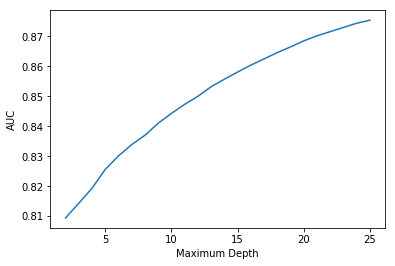

In [13]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(2,26):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(2,26),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

In [14]:
### Using grid search to find the optimal maximum tree depth
auc_by_d=[]
for d in range(26,31):
    rf = RandomForestClassifier(n_estimators=200, criterion="entropy", 
                                max_depth=d,
                                random_state=0, n_jobs=20, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_d.append(auc)
    print("Max_depth =", d)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(26,31),auc_by_d)
plt.xlabel("Maximum Depth")
plt.ylabel("AUC")
plt.show()

Max_depth = 26
Mean CV AUC: 0.8764

Max_depth = 27
Mean CV AUC: 0.8774

Max_depth = 28
Mean CV AUC: 0.8783



KeyboardInterrupt: 

Number of Trees = 100
Mean CV AUC: 0.8756

Number of Trees = 120
Mean CV AUC: 0.8761

Number of Trees = 140
Mean CV AUC: 0.8766

Number of Trees = 160
Mean CV AUC: 0.877

Number of Trees = 180
Mean CV AUC: 0.8772

Number of Trees = 200
Mean CV AUC: 0.8774

Number of Trees = 220
Mean CV AUC: 0.8776

Number of Trees = 240
Mean CV AUC: 0.8777

Number of Trees = 260
Mean CV AUC: 0.8779

Number of Trees = 280
Mean CV AUC: 0.878

Number of Trees = 300
Mean CV AUC: 0.8781



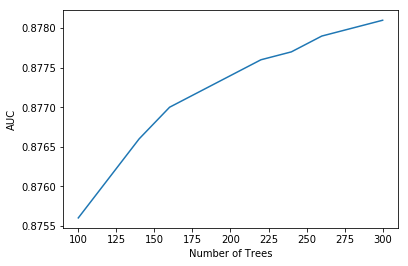

In [15]:
### Using grid search to find the optimal number of estimators (trees)
auc_by_n = []
for n in range(100,320,20):
    rf = RandomForestClassifier(n_estimators=n, criterion="entropy", 
                                max_depth=27,
                                random_state=0, n_jobs=-1, max_features="auto",
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_n.append(auc)
    print("Number of Trees =", n)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(100,320,20), auc_by_n)
plt.xlabel("Number of Trees")
plt.ylabel("AUC")
plt.show()

In [16]:
### Using grid search to find the optimal maximum number of features (trees)
auc_by_nf = []
max_nf = int(np.floor(2*np.sqrt(len(predictors))))
for nf in range(10,max_nf+1):
    rf = RandomForestClassifier(n_estimators=220, criterion="entropy", 
                                max_depth=27,
                                random_state=0, n_jobs=-1, max_features=nf,
                                class_weight = calc_cw(train_df.grade))
    auc = cross_validation_RF(rf, five_folds)
    auc_by_nf.append(auc)
    print("Max_features =", nf)
    print("Mean CV AUC:", auc)
    print("")
plt.plot(range(10,max_nf+1), auc_by_nf)
plt.xlabel("Maximum Number of Features")
plt.ylabel("AUC")
plt.show()

Max_features = 10
Mean CV AUC: 0.8718

Max_features = 11
Mean CV AUC: 0.8732

Max_features = 12
Mean CV AUC: 0.8742

Max_features = 13
Mean CV AUC: 0.875

Max_features = 14
Mean CV AUC: 0.8755

Max_features = 15
Mean CV AUC: 0.8763

Max_features = 16
Mean CV AUC: 0.8768

Max_features = 17
Mean CV AUC: 0.8773

Max_features = 18
Mean CV AUC: 0.8776

Max_features = 19
Mean CV AUC: 0.8779

Max_features = 20
Mean CV AUC: 0.8781

Max_features = 21
Mean CV AUC: 0.8783

Max_features = 22
Mean CV AUC: 0.8786



KeyboardInterrupt: 

In [8]:
rf = RandomForestClassifier(n_estimators=220, criterion="entropy",
                            max_depth=27,
                            random_state=0, n_jobs=-1, max_features=17,
                            class_weight = calc_cw(train_df.grade))
rf.fit(train_df.loc[:,predictors], train_df.grade)

RandomForestClassifier(bootstrap=True, class_weight={0: 1.9044098, 1: 1.0},
            criterion='entropy', max_depth=27, max_features=17,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=220, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [9]:
print("Random Forest:")
print("AUC = {}".format(round(roc_auc_score(test_df.grade, rf.predict_proba(test_df.loc[:,predictors])[:,1]),4)))
y_test_pred_rf = rf.predict_proba(test_df.loc[:,predictors])[:,1]
y_train_pred_rf = rf.predict_proba(train_df.loc[:,predictors])[:,1]

Random Forest:
AUC = 0.8719


In [ ]:
best_threshold = np.sort(y_test_pred_rf)[int(len(y_test_pred_rf) * (1-np.mean(train_df.grade)))-1]
y_test_pred_rf_bin = np.where(y_test_pred_rf > best_threshold, 1, 0)

In [ ]:
threshold_train = np.sort(y_train_pred_rf)[int(len(y_train_pred_rf) * (1-np.mean(train_df.grade)))-1]
y_train_pred_rf_bin = np.where(y_train_pred_rf > threshold_train, 1, 0)

#### Create the data set for storing the predicted scores of admin+lms, admin_only, lms_only RF models

In [ ]:
info_df_test = test_df.loc[:,['vccsid', 'strm', 'college', 'course', 'section'] + predictors]
info_df_test.loc[:,'actual_grade'] = original_test_grade
info_df_test.loc[:,'predicted_binary_outcome_full_predictor'] = y_test_pred_rf_bin
info_df_test.loc[:,'predicted_score_full_predictor'] = y_test_pred_rf
info_df_test = info_df_test.loc[:, ['vccsid', 'strm', 'college', 'course', 'section', 'predicted_score_full_predictor', 'predicted_binary_outcome_full_predictor', 'actual_grade'] + predictors]

In [ ]:
lms_1 = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\updated\\LMS_data_updated.dta").drop(['grade'], axis=1)

In [ ]:
print(info_df_test.shape)
info_df_test = info_df_test.merge(lms_1, on=['vccsid', 'strm', 'college', 'course', 'section'], how='left')
print(info_df_test.shape)

In [ ]:
for cn in info_df_test.columns.values:
    if cn.endswith("_x"):
        info_df_test.rename(columns = {cn: cn[:-2]}, inplace=True)
    if cn.endswith("_y"):
        info_df_test.rename(columns = {cn: cn[:-1] + "raw"}, inplace=True)

In [ ]:
info_df_train = train_df.loc[:,['vccsid', 'strm', 'college', 'course', 'section'] + predictors]
info_df_train.loc[:,'actual_grade'] = original_train_grade
info_df_train.loc[:,'predicted_binary_outcome_full_predictor'] = y_train_pred_rf_bin
info_df_train.loc[:,'predicted_score_full_predictor'] = y_train_pred_rf
info_df_train = info_df_train.loc[:, ['vccsid', 'strm', 'college', 'course', 'section', 'predicted_score_full_predictor', 'predicted_binary_outcome_full_predictor', 'actual_grade'] + predictors]

In [ ]:
print(info_df_train.shape)
info_df_train = info_df_train.merge(lms_1, on=['vccsid', 'strm', 'college', 'course', 'section'], how='left')
print(info_df_train.shape)

In [ ]:
for cn in info_df_train.columns.values:
    if cn.endswith("_x"):
        info_df_train.rename(columns = {cn: cn[:-2]}, inplace=True)
    if cn.endswith("_y"):
        info_df_train.rename(columns = {cn: cn[:-1] + "raw"}, inplace=True)

In [ ]:
info_df_train.loc[:,'is_validation'] = 0
info_df_test.loc[:,'is_validation'] = 1
info_df = pd.concat([info_df_train, info_df_test])

In [ ]:
### After executing the scripts "RF_admin_only.ipynb" and "RF_lms_only.ipynb":
print(info_df.shape)
info_df = info_df.merge(pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\updated\\info_df_admin_only.csv"), on=['vccsid', 'strm', 'college', 'course', 'section']).merge(pd.read_csv("~\\Box Sync\\Clickstream\\data\\full\\updated\\info_df_lms_only.csv"), on=['vccsid', 'strm', 'college', 'course', 'section'])
print(info_df.shape)

In [ ]:
var_list_1 = ['vccsid', 'strm', 'college', 'course', 'section', 'is_validation', 'predicted_score_full_predictor', 'predicted_binary_outcome_full_predictor', 'predicted_score_admin_only', 'predicted_binary_outcome_admin_only', 'predicted_score_lms_only', 'predicted_binary_outcome_lms_only']
var_list_2 = [p for p in info_df.columns.values if p not in set(var_list_1)]
var_list = var_list_1 + var_list_2
info_df = info_df.loc[:,var_list]

In [ ]:
info_df.to_csv("~\\Box Sync\\Clickstream\\data\\full\\updated\\nonfirst_term_dataset.csv", index=False)

#### Compare online vs. in-person courses

In [ ]:
import pickle
pickle.dump(list(y_test_pred_rf), open(results_dir + "y_test_pred_full.p", "wb"))
pickle.dump(list(test_df.grade),  open(results_dir + "y_test_full.p", "wb"))

In [14]:
# import pickle
# y_test_pred_rf = pickle.load(open(results_dir + "y_test_pred_full.p", "rb"))
# y_test_grade = pickle.load(open(results_dir + "y_test_full.p", "rb"))

In [15]:
online_ind_df = pd.read_stata("~\\Box Sync\\Clickstream\\data\\full\\updated_online_ind.dta")

In [30]:
online_ind = test_df.merge(online_ind_df, how='inner', on=['vccsid','strm','college','course','section']).online_ind_y
inperson_ind = test_df.merge(online_ind_df, how='inner', on=['vccsid','strm','college','course','section']).inperson_ind

In [31]:
print("Random Forest:")
print("Onine AUC = {}".format(round(roc_auc_score(test_df[np.array(online_ind == 1)].grade, np.array(y_test_pred_rf)[np.array(online_ind == 1)]),4)))

Random Forest:
Onine AUC = 0.8705


In [32]:
print("Random Forest:")
print("In-person AUC = {}".format(round(roc_auc_score(test_df[np.array(inperson_ind == 1)].grade, np.array(y_test_pred_rf)[np.array(inperson_ind == 1)]),4)))

Random Forest:
In-person AUC = 0.8642


#### Create crosswalk

In [ ]:
cluster_dict = {'EGR': 'engineering',
                'FLA': 'foreign languages',
                'HUM': 'humanities',
                'SOC': 'social sciences',
                'OCC': 'applied technologies',
                'MTH': 'mathematics',
                'BUS': 'business/finance',
                'MED': 'medical sciences',
                'SCI': 'natural sciences',
                'ART': 'arts'}

In [ ]:
import re
cluster_specific = [e for e in all_admin if re.search('^[A-Z]{3}_[A-Z]{3}', e)]
cw_0 = {}
for p in cluster_specific:
    c1,c2 = p.split("_")[0], p.split("_")[1]
    c1 = cluster_dict[c1]
    c2 = cluster_dict[c2]
    if p.endswith("grade") == False:
        cw_0[p] = "whether the target course belongs to the subject of {0} and the student has taken prior courses in the subject {1}".format(c1,c2)
    else:
        cw_0[p] = "the average grades of prior courses that belong to the subject of {0}, if the target course belongs to the subject of {1} and the student has taken prior courses in the subject {2}".format(c2,c1,c2)

In [ ]:
non_course_specific = {'ever_dual', 'num_of_prior_terms', 'pct_stopped', 
                       'pct_withdrawn', 'pct_dev', 'pct_incomplete', 
                       'eve_share', 'online_share', 'lvl2_share', 'dev', 
                       'degree_level_1', 'degree_level_2', 'degree_level_3',
                       'crnt_enrl_intensity', 'enrl_intensity', 
                       'cum_cred_earn', 'enrl_intensity_trend',
                       'cum_gpa', 'gpa_trend', 
                       'has_term_gpa_1', 'term_gpa_1', 'has_term_gpa_2', 'term_gpa_2',
                       'overall_prop_comp', 'prop_comp_sd'}
course_specific = {'has_repeat_grade', 'repeat_grade', 'has_prereq_grade', 'prereq_grade', 
                   'has_avg_g_concurrent', 'avg_g_concurrent', 'avg_g',
                   'summer_ind', 'section_size', 'eve_ind', 'online_ind', 'lvl2_ind'}
course_specific = course_specific | set([e for e in predictors if e.startswith("college_")])
non_course_specific = non_course_specific | set([e for e in predictors if e.startswith("cip_")])
instructor_related = {'full_time', 'tenure', 'has_past_avg_grade', 'past_avg_grade'}

In [ ]:
cw_1 = {'summer_ind': 'whether the target course was taken during a summer term',
        'section_size': 'total number of students in the target course section',
        'eve_ind': 'whether the course meeting times are in the evening',
        'online_ind': 'whether the course section is online',
        'lvl2_ind': 'whether the target course is a 2XX-level course',
        'has_repeat_grade': 'whether the student took the target course in the past',
        'repeat_grade': 'the average grade received in the target course, if the student took the target course in the past',
        'has_prereq_grade': 'whether the course has prerequisites and the student had taken the prerequisite courses in the past',
        'prereq_grade': 'the average grade received in the prerequisite courses, if the course has prerequisites and the student had taken the prerequisite coures in the past',
        'avg_g': 'the average grade of the target course (for all students) during the 5 years prior to the target term',
        'has_avg_g_concurrent': 'whether the student is taking concurrent courses and the average grades of those concurrent courses (for all students) during the 5 years prior to the target term are available',
        'avg_g_concurrent': 'the average of the average grades of all concurrent courses (for all students) during the 5 years prior to the target term', 
        'cum_gpa': 'cumulative GPA of the student at the beginning of the target term',
        'cum_cred_earn': 'total number of college-level credit hours earned by the student so far',
        'age': 'age of the student at the target term',
        'num_of_prior_terms': 'number of terms in which the student has actively enrolled in VCCS',
        'pct_stopped': 'among all prior terms since the student has first enrolled in VCCS, the percentage in which the student was not actively enrolled in VCCS',
        'pct_withdrawn': 'among all credit hours the student has ever attempted, the percentage of withdrawn credits',
        'pct_incomplete': 'among all credit hours the student has ever attempted, the percentage of credit hours ends up with "I"',
        'pct_dev': 'among all credit hours the student has ever attempted, the percentage of credits which are developmental courses',
        'prop_comp_sd': 'the standard deviation of term-level proportion of credits earned in all prior actively enrolled terms',
        'overall_prop_comp': 'the overall proportion of credits earned in all prior actively enrolled terms',
        'crnt_enrl_intensity': 'the total number of credit hours attempted in the target term',
        'enrl_intensity': 'the total number of credit hours attempted in the term right prior to the target term',
        'has_term_gpa_1': 'whether the term GPA value is available in the term right prior to the target term',
        'term_gpa_1': 'the term GPA of the term right prior to the target term, if it is available in that term',
        'has_term_gpa_2': 'whether the term GPA value is available in the second-to-last term prior to the target term',
        'term_gpa_2': 'the term GPA of the second-to-last term prior to the target term, if it is available in that term',
        'gpa_trend': 'the slope of term-level GPA values in all prior actively enrolled terms',
        'enrl_intensity_trend': 'the slope of term-level number of credits attempted in all prior actively enrolled terms',
        'ever_dual': 'whether the student has ever dually enrolled',
        'dev': 'whether the student is enrolled in any developmental courses in the target term',
        'lvl2_share': 'share of credits hours attempted that are 2XX-level courses in the target term',
        'eve_share': 'share of credits hours attempted that are courses whose meeting times are in the evening',
        'online_share': 'share of credits hours attempted that are online courses',
        'degree_level_1': 'whether the student is enrolled in a transfer-oriented associate degree program',
        'degree_level_2': 'whether the student is enrolled in an occupation-oriented associate degree program',
        'degree_level_3': 'whether the student is enrolled in a certificate program',
        'has_past_avg_grade': 'whether the instructor had taught the target course in the past',
        'past_avg_grade': 'the average course grade assigned by the instructor to the target course, if the instructor had taught the target course in the past',
        'full_time': 'whether the instructor works full-time at VCCS',
        'tenure': 'whether the instructor holds a tenure position at VCCS (has been teaching at VCCS for 6+ years)'}

In [ ]:
cw_2 = {e: "whether the 2-digit CIP code for the student is {}".format(e.replace("cip_", "")) for e in all_admin if e.startswith("cip_") and e != "cip_99"}
cw_2["cip_99"] = "whether the 2-digit CIP code for the student is anything else, whose frequency is less than 0.5%"
for e in all_admin:
    if e.startswith("college_"):
        cw_2[e] = "whether the target course is taken at {}".format(e.replace("college_", ""))

In [ ]:
cw_3 = {'has_assign_sub_cnt_qtr1': 'whether the number of assignment submissions in the first quarter of course period is available',
        'assign_sub_cnt_qtr1': 'the number of assignment submissions in the first quarter of course period, if this information is available',
        'on_time_assign_share_qtr1': 'share of on-time assignment submissions in the first quarter of course period, if this information is available',
        'has_on_time_assign_share_qtr1': 'whether the share of on-time assignment submissions in the first quarter of course period is available',
        'tot_click_cnt_qrt1': 'total number of clicks in the first quarter of course period',
        'tot_time_qrt1': 'total time spent (min) in the first quarter of course period',
        'avg_session_len_qrt1': 'average session duration (min) in the first quarter of course period',
        'irreg_session_len_qrt1': 'irregularity of study effort (STD of study session lengths) (min) in the first quarter of course period',
        'disc_post_cnt_qtr1': 'number of original discussion forum posts created in the first quarter of course period',
        'disc_reply_cnt_qtr1': 'number of discussion forum replies in the first quarter of course period',
        'avg_word_tot_qtr1': 'average total number of words per discussion forum thread in the first quarter of course period',
        'avg_depth_post_qtr1': 'average depth (position) of posts within a discussion forum thread (original post = 1) in the first quarter of course period',
        'has_concurrent_qtr1': 'whether the student is taking other courses concurrently with the target course and those concurrent courses have the LMS measures available',
        'has_assign_sub_cnt_qtr1c': 'whether the number of assignment submissions in the first quarters of course periods of concurrent courses is available',
        'assign_sub_cnt_qtr1c': 'the average number of assignment submissions in the first quarters of course periods of all concurrent courses, if this information is available',
        'has_on_time_assign_share_qtr1c': 'whether the share of on-time assignment submissions in the first quarters of course periods of concurrent courses is available',
        'on_time_assign_share_qtr1c': 'average share of on-time assignment submissions in the first quarters of course periods of all concurrent courses, if this information is available',
        'tot_click_cnt_qrt1c': 'average total number of clicks in the first quarters of course periods of all concurrent courses',
        'tot_time_qrt1c': 'average total time spent (min) in the first quarters of course periods of all concurrent courses',
        'avg_session_len_qrt1c': 'the average of average session duration (min) in the first quarters of course periods of all concurrent courses',
        'irreg_session_len_qrt1c': 'the average of irregularity of study effort (STD of study session lengths) (min) in the first quarters of course periods of all concurrent courses',
        'prior_has_full': 'whether the prior courses taken by the student have any full-term LMS measures available',
        'prior_has_assign_sub_cnt': 'whether the number of assignment submissions in the full course period of any prior course is available',
        'prior_assign_sub_cnt': 'the average of the number of assignment submissions in the full course periods of all prior courses, if this information is available',
        'prior_on_time_assign_share': 'the average of the share of on-time assignment submissions in the full course periods of all prior courses, if this information is available',
        'prior_has_on_time_assign_share': 'whether the share of on-time assignment submissions in the full course period of any prior course is available',
        'prior_tot_click_cnt': 'the average of total numbers of clicks in the full course periods of all prior courses',
        'prior_tot_time': 'the average of total time spent (min) in the full course periods of all prior courses',
        'prior_tot_act_day_cnt': "the average of total number of days with any activity in the full course periods of all prior courses",
        'prior_tot_act_wk_cnt': "the average of total number of weeks with any activity in the full course periods of all prior courses",
        'prior_tot_session_cnt': "the average of total number of sessions in the full course periods of all prior courses (a session is the time period between a login and the following logout -- this is equivalent to total number of logins)",
        'prior_avg_session_len': 'the average of average session durations (min) in the full course periods of all prior courses',
        'prior_irreg_session_len': 'the average of irregularity of study effort (STD of study session lengths) (min) in the full course periods of all prior courses',
        'prior_disc_post_cnt': 'the average of numbers of original discussion forum posts created in the full course periods of all prior courses',
        'prior_disc_reply_cnt': 'the average of numbers of discussion forum replies in the full course periods of all courses',
        'prior_avg_word_tot': 'the average of average total number of words per discussion forum thread in the full course periods of all courses',
        'prior_avg_depth_post': 'the average of average depth (position) of posts within a discussion forum thread (original post = 1) in the full course periods of all courses',
        'prior_has_qtr1': 'whether the prior courses taken by the student have any early-term LMS measures available',
        'prior_has_assign_sub_cnt_qtr1': 'whether the number of assignment submissions in the first quarter of course period of any prior course is available',
        'prior_assign_sub_cnt_qtr1': 'the average of the number of assignment submissions in the first quarter of course periods of all prior courses, if this information is available',
        'prior_on_time_assign_share_qtr1': 'the average of share of on-time assignment submissions in the first quarter of course periods of all prior courses, if this information is available',
        'prior_has_on_time_assign_share_qtr1': 'whether the share of on-time assignment submissions in the first quarter of course period of any prior course is available',
        'prior_tot_click_cnt_qrt1': 'the average of total number of clicks in the first quarter of course periods of all prior courses',
        'prior_tot_time_qrt1': 'the average of total time spent (min) in the first quarter of course periods of all prior courses',
        'prior_avg_session_len_qrt1': 'the average of average session duration (min) in the first quarter of course periods of all prior courses',
        'prior_irreg_session_len_qrt1': 'the average of irregularity of study effort (STD of study session lengths) (min) in the first quarter of course periods of all prior courses',
        'prior_disc_post_cnt_qtr1': 'the average of number of original discussion forum posts created in the first quarter of course periods of all prior courses',
        'prior_disc_reply_cnt_qtr1': 'the average of number of discussion forum replies in the first quarter of course periods of all prior courses',
        'prior_avg_word_tot_qtr1': 'the average of average total number of words per discussion forum thread in the first quarter of course periods of all prior courses',
        'prior_avg_depth_post_qtr1': 'the average of average depth (position) of posts within a discussion forum thread (original post = 1) in the first quarter of course periods of all prior courses'}

In [ ]:
cw = {**cw_0, **cw_1, **cw_2, **cw_3}
cw_df = pd.DataFrame.from_dict(cw, orient='index').reset_index().rename(columns={'index':'predictor',
                                                                                 0: 'predictor_meaning'})

In [ ]:
fi_df = pd.DataFrame({"feature_importance": rf.feature_importances_, "predictor": predictors})\
.loc[:,['predictor', 'feature_importance']].sort_values(['feature_importance'], ascending=False)
# fi_df.loc[:,'feature_ranking'] = np.arange(1, fi_df.shape[0] + 1) / fi_df.shape[0]

In [ ]:
cw_df = cw_df.merge(fi_df, on=['predictor'], how='inner').sort_values(['feature_importance'], ascending=False)

In [ ]:
cw_df.loc[:,'predictor_category'] = cw_df.predictor.apply(lambda x: "LMS" if x in set(all_lms) else "Admin")

In [ ]:
def lms_type2(x):
    if x in click_lms:
        return "click/session/time"
    elif x in assign_lms:
        return "assignments"
    else:
        return "discussion forums"

def sub_category(x):
    if x == "age":
        return "Demographic"
    elif x in cluster_specific:
        return "Course-subject-specific"
    elif x in instructor_related:
        return "Instructor-related"
    elif x in course_specific:
        return "Course-specific"
    elif x in non_course_specific:
        return "Non-course-specific academic records"
    elif x in early_lms:
        return "Early-term & " + lms_type2(x)
    elif x in concurrent_lms:
        return "Early-term concurrent & " + lms_type2(x)
    elif x in historical_early_lms:
        return "Prior early-term & " +  lms_type2(x)
    elif x in historical_full_lms:
        return "Prior full-term & " + lms_type2(x)

In [ ]:
cw_df.loc[:,'predictor_subcategory'] = cw_df.predictor.apply(lambda x: sub_category(x))

In [ ]:
cw_df.to_csv(results_dir + "predictor_crosswalk.csv", index=False)

#### Feature importances

In [57]:
cw_df = pd.read_csv(results_dir + "predictor_crosswalk.csv").iloc[:,[0,1,3,4]]

In [58]:
fi_df = pd.DataFrame({"feature_importance": rf.feature_importances_, "predictor": predictors})\
.loc[:,['predictor', 'feature_importance']].sort_values(['feature_importance'], ascending=False)
fi_df.loc[:,'feature_ranking'] = np.arange(1, fi_df.shape[0] + 1) / fi_df.shape[0]

In [59]:
early_lms = [e for e in predictors if (e.endswith("_qtr1") or e.endswith("_qrt1")) and (e != "has_concurrent_qtr1") and (e.startswith("prior_") == False)]
concurrent_lms = [e for e in predictors if e.endswith("_qtr1c") or e.endswith("_qrt1c") or e == 'has_concurrent_qtr1']
historical_early_lms = [e for e in predictors if e.startswith("prior") and (e.endswith("_qrt1") or e.endswith("_qtr1"))]
historical_full_lms = [e for e in predictors if e.startswith("prior") and e.endswith("_qrt1") == False and e.endswith("_qtr1") == False]
all_lms = early_lms + concurrent_lms + historical_early_lms + historical_full_lms
# assign_lms = [e for e in all_lms if "assign" in e]
# disc_lms = [e for e in all_lms if "disc" in e or "word" in e or "post" in e]
# click_lms = [e for e in all_lms if e not in assign_lms + disc_lms]
all_admin = [e for e in predictors if e not in set(all_lms)]

In [60]:
fi_df_top30 = fi_df.iloc[:30,:]
fi_df_top30.loc[:,'feature_ranking'] = np.arange(1,31)
fi_df_top30 = fi_df_top30.round(3)
fi_df_top30.loc[:,'predictor_type'] = fi_df_top30.predictor.apply(lambda x: "LMS" if x in set(all_lms) else "Admin")
fi_df_top30 = fi_df_top30.rename(columns = {'feature_importance': 'feature_importance_score',
                                            'feature_ranking': 'ranking'})
fi_df_top30 = fi_df_top30.loc[:,['predictor', 'predictor_type', 'ranking', 'feature_importance_score']]
fi_df_top30 = fi_df_top30.merge(cw_df.loc[:,['predictor', 'predictor_subcategory']], how='inner', on=['predictor'])
fi_df_top30.loc[:,'predictor_subcategory'] = fi_df_top30.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_df_top30 = fi_df_top30.loc[:,['predictor', 'predictor_type', 'predictor_subcategory', 'ranking', 'feature_importance_score']]
fi_df_top30.to_csv(results_dir + "top30_predictors.csv", index=False)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [61]:
# fi_results = []
# for c in ['early_lms', 'concurrent_lms', 'historical_early_lms', 'historical_full_lms', 'all_lms', 'all_admin']:
#     l = fi_df.merge(pd.DataFrame({'predictor': eval(c)}), how='inner', on=['predictor']).feature_ranking
#     fi_results.append((c, len(l), l.iloc[0], l.mean()))
# # fi_results

In [62]:
# category_dict = {'early_lms': "Early-term LMS",
#                  'concurrent_lms': 'Early-term concurrent LMS',
#                  'historical_early_lms': 'Historical early-term LMS',
#                  'historical_full_lms': 'Historical full-term LMS',
# #                  'click_lms': 'LMS -- clicks/session/time',
# #                  'assign_lms': 'LMS -- assignments',
# #                  'disc_lms': 'LMS -- discussion forums',
#                  'all_lms': 'All LMS',
#                  'all_admin': 'All admin'}
# # fi_df = pd.DataFrame(fi_results, columns=['predictor_category', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']).round(3)
# # fi_df.loc[:,'predictor_category'] = fi_df.predictor_category.apply(lambda x: category_dict[x])
# # fi_df

In [63]:
fi_df = fi_df.merge(cw_df.loc[:,['predictor', 'predictor_category', 'predictor_subcategory']], on=['predictor'])
fi_part1 = fi_df.iloc[:,:-1]
fi_part1.loc[:,'predictor_category'] = fi_part1.predictor_category.apply(lambda x: "All " + x)
fi_part2 = fi_df.copy()
fi_part2.loc[:,'predictor_subcategory'] = fi_part2.predictor_subcategory.apply(lambda x: x.split(" & ")[0])
fi_part2.loc[:,'predictor_subcategory'] = fi_part2.predictor_category + " -- " + fi_part2.predictor_subcategory
# fi_part3 = fi_df.copy()
# fi_part3.loc[:,'predictor_subcategory'] = fi_part3.predictor_subcategory.apply(lambda x: x.split(" & ")[-1])
# fi_part3 = fi_part3[fi_part3.predictor_category == "LMS"]
# fi_part3.loc[:,'predictor_subcategory'] = fi_part3.predictor_category + " -- " + fi_part3.predictor_subcategory

In [64]:
fi_part2 = fi_part2.groupby(['predictor_subcategory']).agg({'feature_ranking': ['count','first','mean']}).reset_index()
fi_part2.columns = ['predictor_subcategory', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']
fi_part2

,predictor_subcategory,number_of_predictors,highest_normalized_ranking,average_normalized_ranking
0,Admin -- Course-specific,34,0.030395,0.479260
1,Admin -- Course-subject-specific,200,0.188450,0.635106
2,Admin -- Demographic,1,0.091185,0.091185
3,Admin -- Instructor-related,4,0.027356,0.213526
4,Admin -- Non-course-specific academic records,40,0.003040,0.311322
5,LMS -- Early-term,12,0.009119,0.079281
6,LMS -- Early-term concurrent,9,0.054711,0.163121
7,LMS -- Prior early-term,13,0.106383,0.218377
8,LMS -- Prior full-term,16,0.094225,0.189210


In [65]:
# fi_part3 = fi_part3.groupby(['predictor_subcategory']).agg({'feature_ranking': ['count','first','mean']}).reset_index()
# fi_part3.columns = ['predictor_subcategory', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']
# fi_part3

In [66]:
fi_part1 = fi_part1.groupby(['predictor_category']).agg({'feature_ranking': ['count','first','mean']}).reset_index()
fi_part1.columns = ['predictor_subcategory', 'number_of_predictors', 'highest_normalized_ranking', 'average_normalized_ranking']
fi_part1

,predictor_subcategory,number_of_predictors,highest_normalized_ranking,average_normalized_ranking
0,All Admin,279,0.003040,0.561700
1,All LMS,50,0.009119,0.165714


In [67]:
fi_all_parts = pd.concat([fi_part2, fi_part1])
fi_all_parts.round(3).to_csv(results_dir + "normalized_feature_ranking.csv", index=False)

In [ ]:
cw_df.loc[:,['predictor', 'predictor_category', 'predictor_subcategory']].to_csv('~\\Box Sync\\Clickstream\\evaluation_results\\first\\predictor_category_table.csv', index=False)

In [13]:
for c in ['ENG_111', 'ENG_112', 'MTH_154', 'MTH_161', 'BIO_101']:
    test_new = test_df[test_df.course == c]
    print(c)
    print("AUC = {}".format(round(roc_auc_score(test_new.grade, rf.predict_proba(test_new.loc[:,predictors])[:,1]),4)))
    print("")

ENG_111
AUC = 0.8657

ENG_112
AUC = 0.8661

MTH_154
AUC = 0.8233

MTH_161
AUC = 0.8

BIO_101
AUC = 0.8563



In [14]:
print("ABC vs. DF")
print("AUC = {}".format(round(roc_auc_score(np.array(test_df.grade)[np.where(np.array(original_test_grade) != "W")[0]], 
                                            rf.predict_proba(test_df.loc[:,predictors])[np.where(np.array(original_test_grade) != "W")[0],1]),4)))

ABC vs. DF
AUC = 0.847


<b>Confusion matrices</b>

In [ ]:
best_threshold = np.sort(y_test_pred_rf)[int(len(y_test_pred_rf) * (1-np.mean(train_df.grade)))-1]

In [ ]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_DFW','Pred_ABC'], index=['Actual_DFW', 'Actual_ABC'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score for A/B/C = {}".format(round(2*p1*r1/(p1+r1),4)))
    print("F1 score for D/F/W = {}".format(round(2*p0*r0/(p0+r0),4))) 
    cm_df.to_csv(results_dir + fname + ".csv")
    y_test_pred_bin = np.where(y_test_pred > best_threshold, 1, 0)
    cm_dict = {}
    cm_dict['Pred_DFW'] = Counter(original_test_grade[np.where(y_test_pred_bin==0)[0]])
    cm_dict['Pred_ABC'] = Counter(original_test_grade[np.where(y_test_pred_bin==1)[0]])
    new_cm = pd.DataFrame.from_dict(cm_dict, orient='index').T.loc[['W','F','D','C','B','A'],['Pred_DFW','Pred_ABC']]
    new_cm.index = ["Actual_"+e for e in new_cm.index]
    new_cm.loc[:,''] = new_cm.sum(axis=1)
    new_cm.loc['',:] = new_cm.sum(axis=0)
    new_cm.to_csv(results_dir + fname + "_6x2.csv")
    return round(p1,4),round(r1,4),round(p0,4),round(r0,4),round(2*p1*r1/(p1+r1),4),round(2*p0*r0/(p0+r0),4)

In [3]:
y_test = np.array(test_df.grade)
print("F1 threshold = {}:\n".format(str(round(best_threshold,4))))
pr_rf = create_confusion_matrix(y_test_pred_rf, best_threshold, "RF_1_full_cm")


F1 threshold = 0.6136:

            Pred_DFW  Pred_ABC          
Actual_DFW   37296.0   22786.0   60082.0
Actual_ABC   21203.0  189379.0  210582.0
             58499.0  212165.0  270664.0

F1 score for A/B/C = 0.8959
F1 score for D/F/W = 0.629



In [4]:
pr_rf

(0.8926, 0.8993, 0.6375, 0.6208, 0.8959, 0.629)
